# What's that Doggy in the Window?
## Explorative Data Analysis

By: **Bryan Santos**

Have you ever wanted to know the breed of dogs you see in social media or with other people because you like how they look, whether tough or cute?

This project aims to build an application that lets users upload images of a dog and to get its breed. The application will then assess the breed characteristics if it is suitable for the user based on lifestyle. If it is, then the system will redirect the user to dogs of that particular breed that is up for adoption. If not compatible, then the the system will suggest top five most compatible breeds.

The project will utilize multi-class image classification and recommendation systems machine learning models to achieve its goals.

The pet industry is a multi-billion dollar industry even just in the United States alone. The trend of owning pets is on a steady rise. Unfortunately, so do the number of dogs that would be without a permanent home or that would be euthanized. Many people buy dogs because of fad or appearances and abandon them, most likely because they do not realize that dogs of different breeds have unique characteristics and may not necessarily match their lifestyles.

***

This notebook contains all explorative data analysis as deep-dives conducted on the various dataset. I will look at various visualizations and write the observations that may play as key factors in the multi-class image classification and recommendation system modeling.

## 1: Package Imports and Data Load

### Package Imports

Below are the libraries needed to visualize data to draw key insights and observations.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')
import cv2
import tqdm
from sklearn.datasets import load_files
from glob import glob
from random import randint
import os
import PIL
import missingno as mno

In [4]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

### Data Load

In [9]:
### Load record of all images and aggregated count
images_df = pd.read_csv('images_df.csv')
count_df = pd.read_csv('count_df.csv')

In [10]:
### Drop unneccesary column then validate
del images_df['Unnamed: 0']
images_df.head(5)

filename         breed
0  yr5nolw2d8qzb9i3scg4.jpg  setter-irish
1  01g4tqhjevrdzo3pl2ky.jpg  setter-irish
2  lhyq7io1ek6gbwuc2tn8.jpg  setter-irish
3  5971pwrfx0hunc3m4el2.jpg  setter-irish
4  o6vqbkigf4n32xmzrls5.jpg  setter-irish

In [11]:
### Drop unneccesary column then validate
del count_df['Unnamed: 0']
count_df.tail(5)

breed  count
168           terrier-smooth-fox     38
169  griffon-wirehaired-pointing     37
170           terrier-manchester     36
171                        plott     35
172             buhund-norwegian     33

In [12]:
### Drop unneccesary column then validate
labels_df = pd.read_csv('labels.csv')
del labels_df['Unnamed: 0']

In [3]:
### Drop unneccesary column then validate
split_df = pd.read_csv('targets_df.csv')
del split_df['Unnamed: 0']

In [36]:
split_df.head(5)

filename    breed
0  m8045hqkl3wiado97pcb.jpg  maltese
1  51n7gcvmu9x2e8wfoql6.jpg  maltese
2  its279rcqnjuz6eao03w.jpg  maltese
3  mzhr9l61d3j4sqogbu5n.jpg  maltese
4  wurbzx6jnvgep8d4mao2.jpg  maltese

## 2: EDA - Images Dataset

This section contains all deep-dives of the images dataset gathered from the two sources.

### What is the class distribution?

In [5]:
count_df = split_df.breed.value_counts()

In [6]:
### Convert to dataframe
count_df = pd.DataFrame(count_df)
count_df = count_df.reset_index()
count_df.columns = ['breed', 'count']

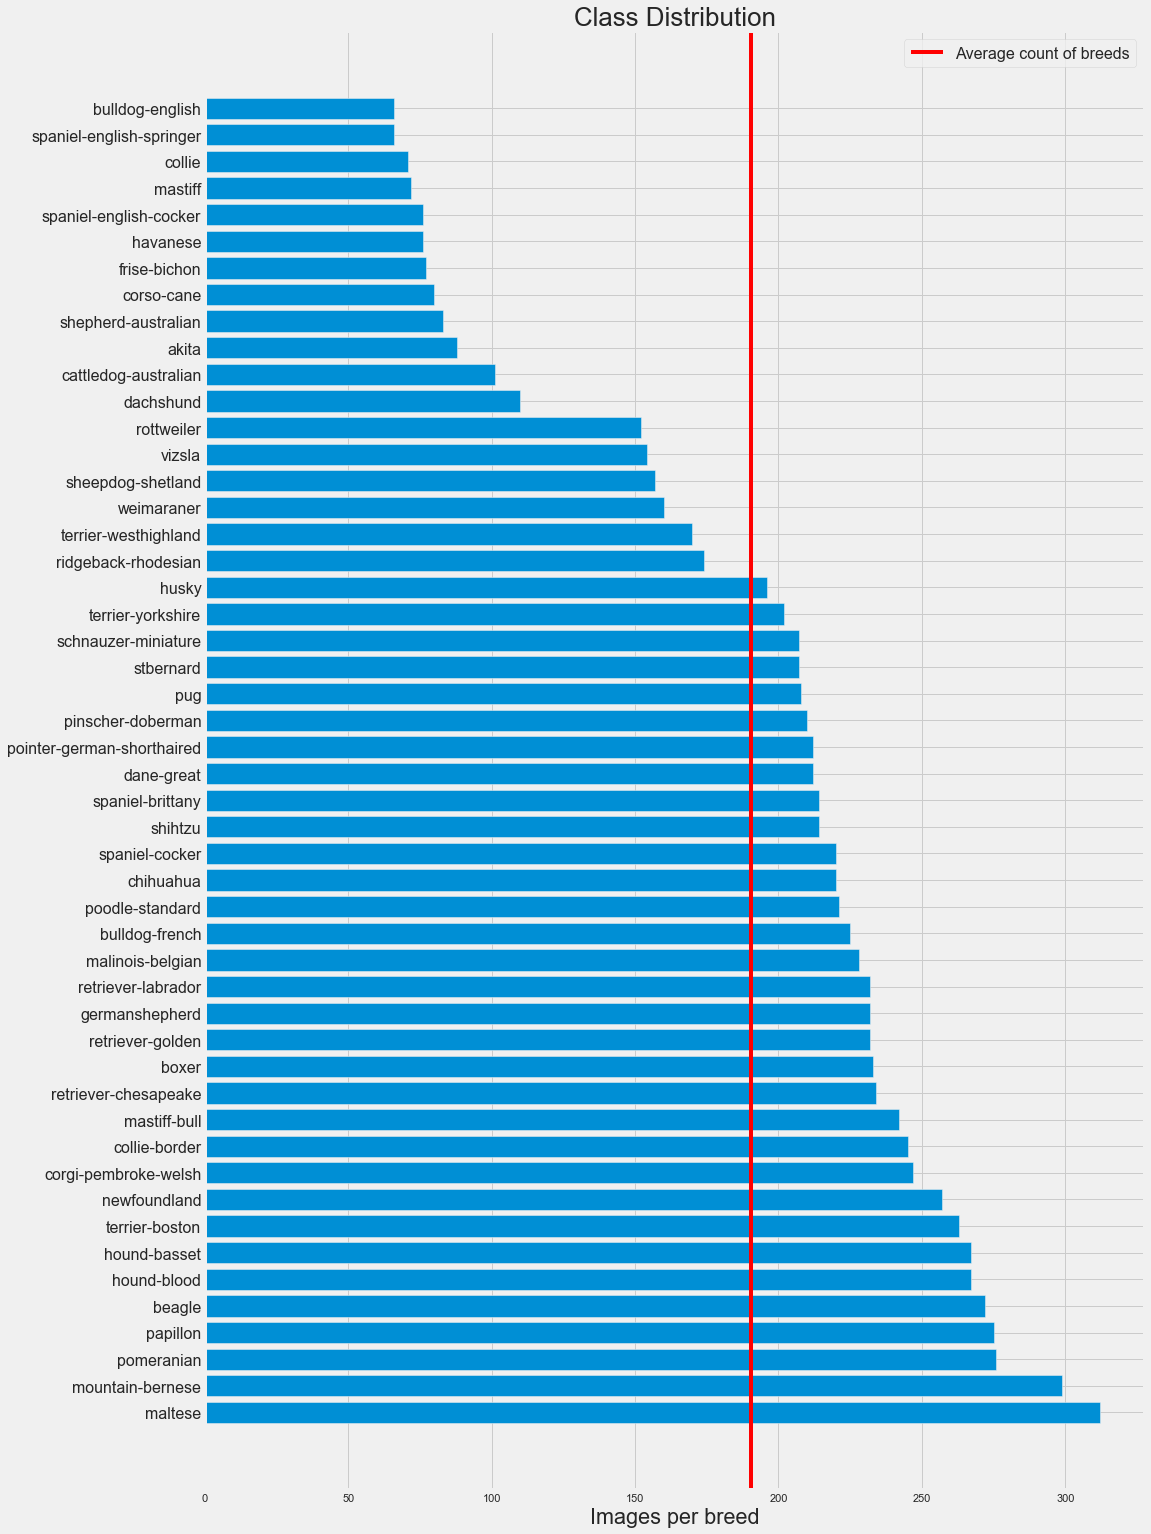

In [13]:
### Plot class distribution

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(15,25))

ax.barh(count_df["breed"],count_df["count"])
ax.axvline(count_df["count"].mean(), color="red", label="Average count of breeds")

ax.set_yticklabels(count_df["breed"], fontsize=16)

ax.set_xlabel("Images per breed")
ax.set_title('Class Distribution')
ax.legend(fontsize=16)

plt.show()

#### Observations:

The first observation that comes to mind is the number of classes. There are a total of 50 breeds making this a complex multi-class image classification. Furthermore, there is also a wide disparity in the amount of images available for each class, resulting to an obvious class imbalance. The red line shows the mean count of all classes and approximate half are quite below the red line. 

There are various ways that I could deal with the class imbalance. I am predicting that our model to be build from scratch will perform very poorly given the lack of observations for half of the breeds. However, I am confident that using pre-trained models via Transfer Learning can help solve this problem. We will compensate the lack of images for some of the breeds by tapping into the other images that the pre-trained models have trained on.

### Random Image

This section just shows a random image so readers will get an idea on the kind of images that this project is using.

In [19]:
def random_image(num):
    '''
    This function shows a sample image in the training set. 
    
    Parameters:
    - Number out of the total images (20,000++)
    
    Output:
    - Displays the image
    
    '''
    image = cv2.imread(train_files[num])
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

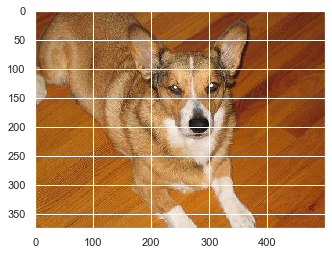

In [20]:
### Show a random image using the function
random_image(5)

### Random Image Grid

This part of the notebook displays random images on a 3x3 grid. The purpose of this is to show the breeds and how much different they look.

In [21]:
def plot_images(images, classes):
    '''
    This function displays nine random images on a 3x3 grid. 
    
    Parameters:
    - images = images to show
    - classes = breeds to show
    
    Output:
    - Displays a 3x3 image greed
    
    '''
    assert len(images) == len(classes) == 9
    
    ### Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        
        ### Plot image
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(img_width,img_height,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        ### Show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        
        ### Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

But before I can display the different dogs, I wanted to first ensure that they are of the same image size so our plot looks standard and consistent.

In [38]:
img_width = 250
img_height = 250
images = []
classes = []

### Load training images
for f, breed in tqdm(split_df.values):
    img = cv2.imread('images/train/' + f)
    classes.append(breed)
    try:
        images.append(cv2.resize(img, (img_width, img_height)))
    except: 
        continue

Images to show: 9
Classes to show: 9


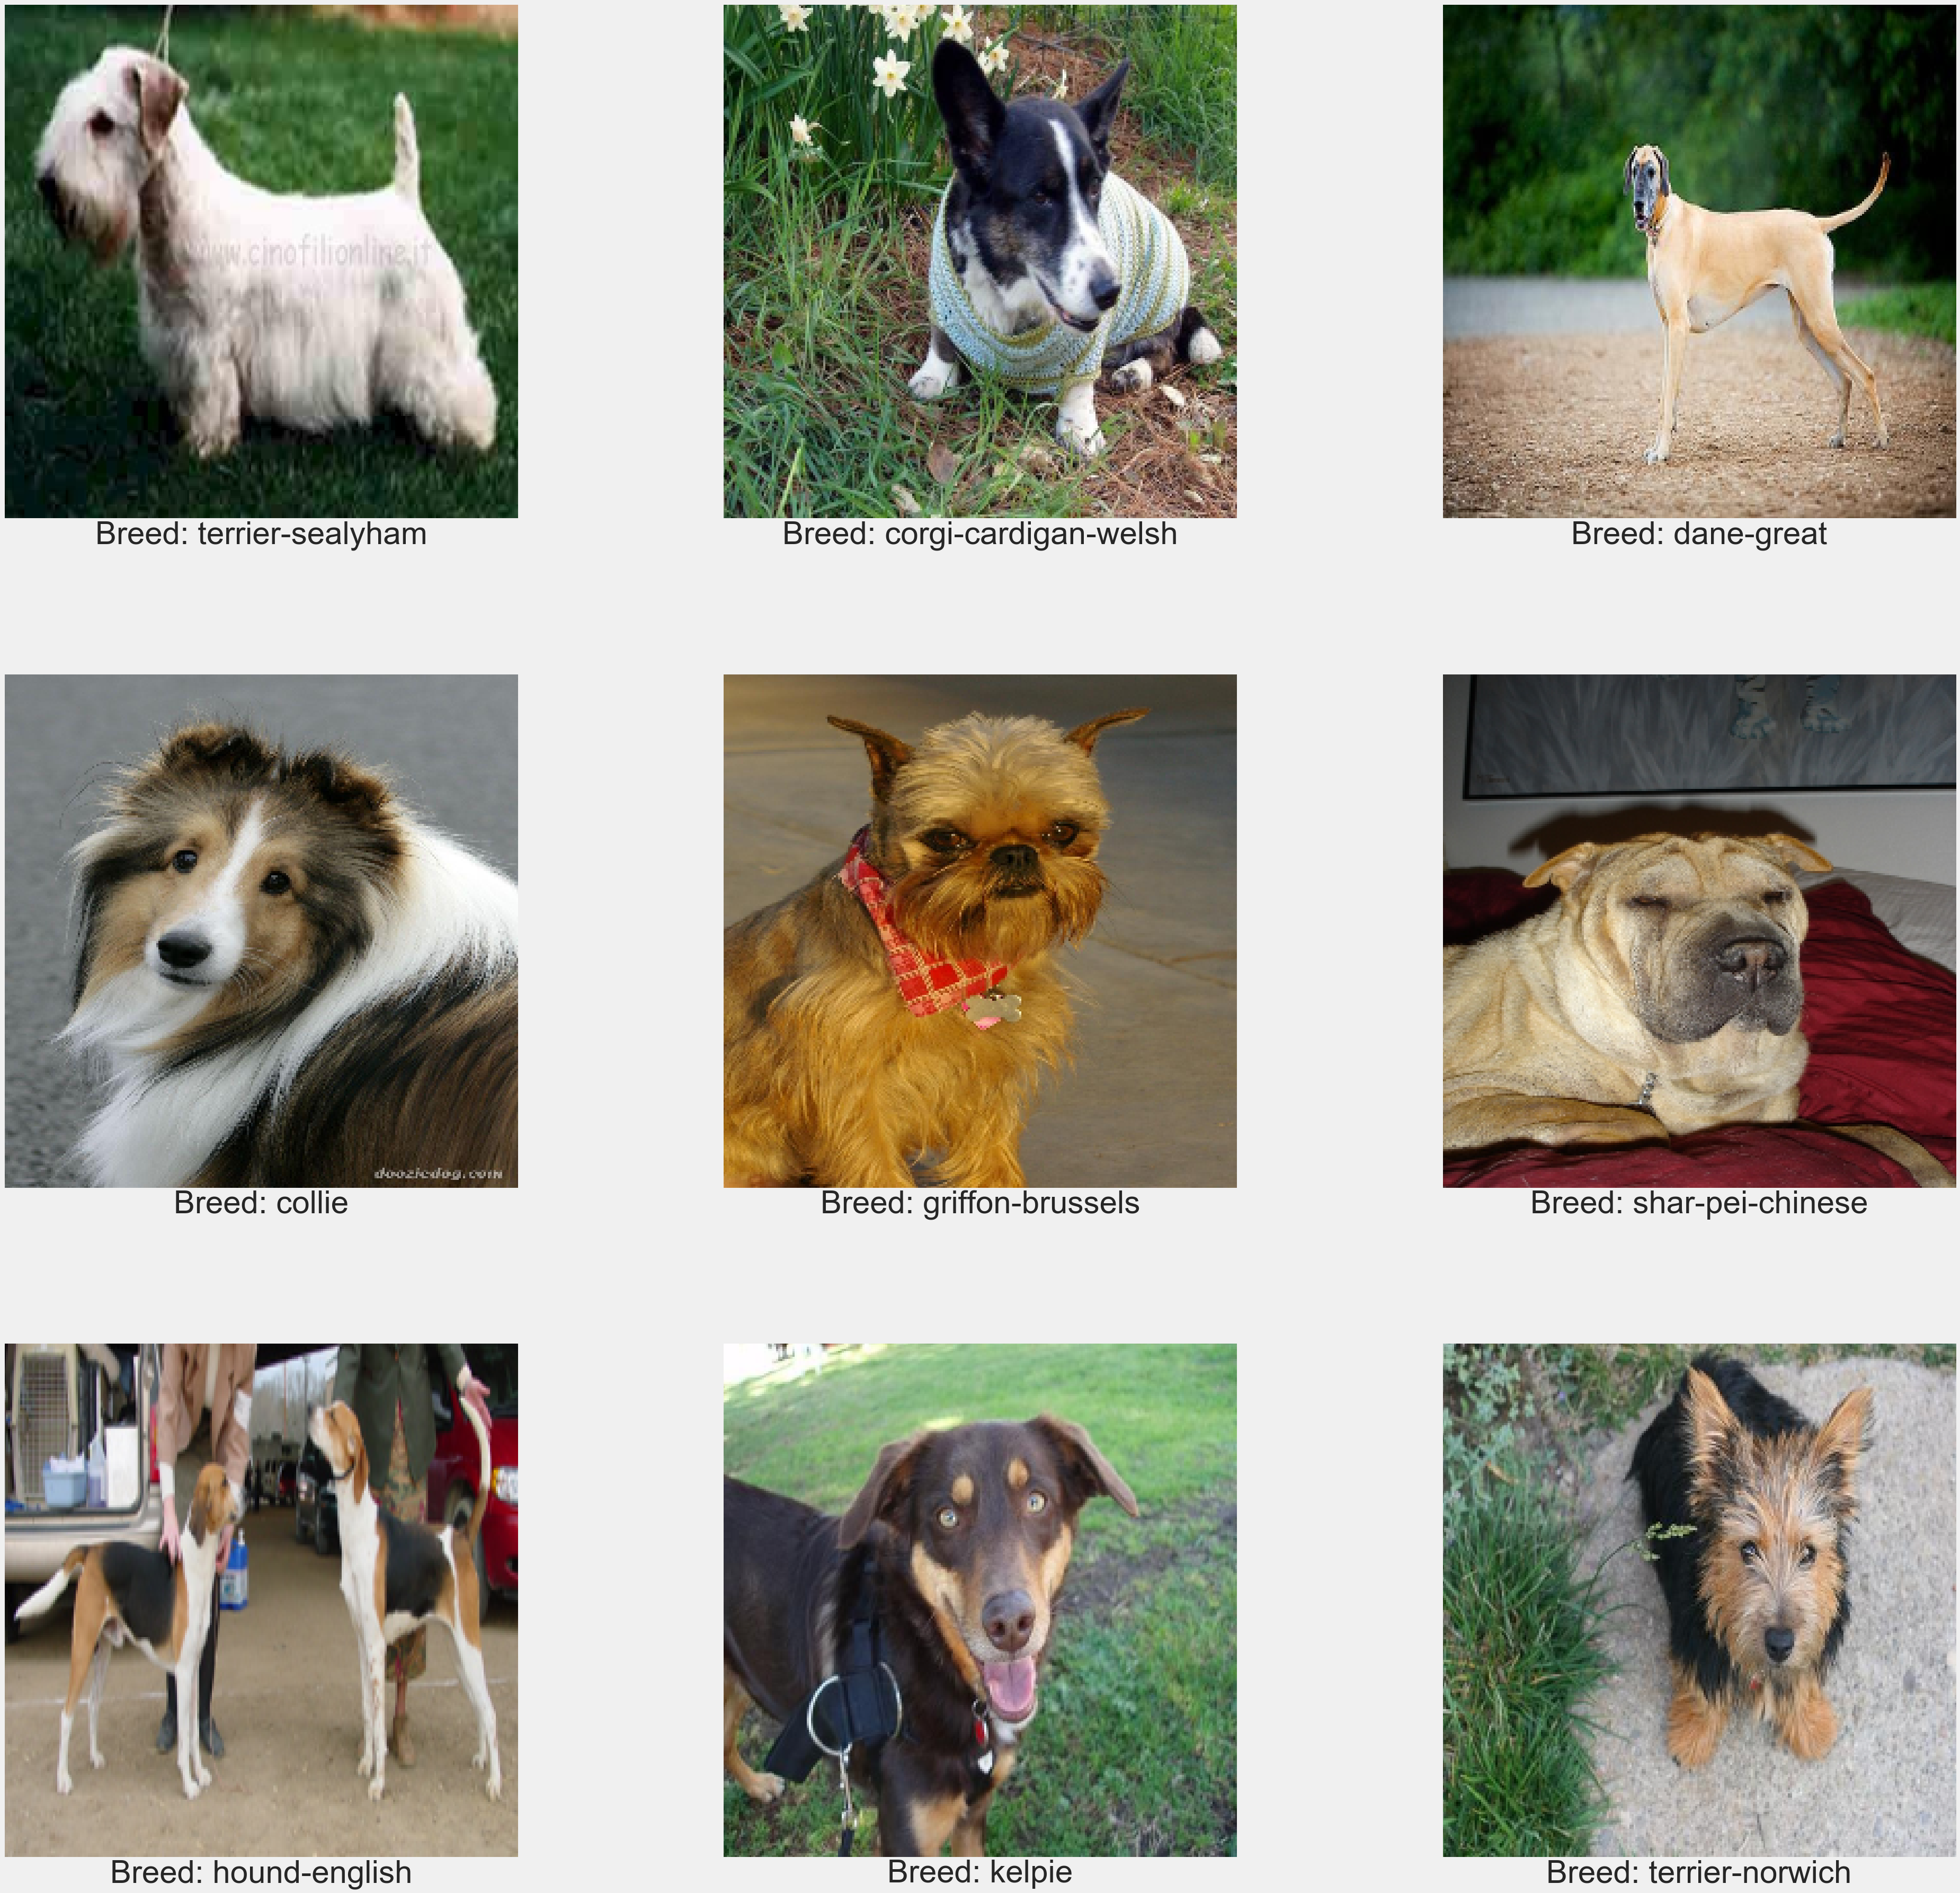

In [40]:
### Select random images
random_numbers = [randint(0, len(images)) for p in range(0,9)]
images_to_show = [images[i] for i in random_numbers]
classes_to_show = [classes[i] for i in random_numbers]
print("Images to show: {0}".format(len(images_to_show)))
print("Classes to show: {0}".format(len(classes_to_show)))

### Plot the images
plot_images(images_to_show, classes_to_show)

#### Observations:

Given the wide variety of dogs as seen in the random images, this proves that there is indeed a need for a dog breed classifier. Normal folks would find it hard to identify a dog's breed because of the significant physical differences and the actual number of breeds there are. 

### Image Sizes

This looks into the file sizes of images. It may be noteworthy to check if file sizes do matter in making predictions.

In [41]:
### Get image paths
path_df = split_df.copy()
path_df.columns

Index(['filename', 'breed'], dtype='object')

In [45]:
path_df['path'] = 'images/train/' + path_df.filename

In [46]:
path_list = path_df.path 

In [51]:
### Prepare a dataframe to store file sizes
sizes_df = pd.DataFrame(columns=['path', 
                                'size']) 

### Get file sizes
for path in tqdm(path_list):
    size = os.path.getsize(path)
    sizes_df = sizes_df.append({'path': path, 'size': size}, ignore_index = True)


### Store file sizes
sizes_df.to_csv('sizes.csv')

In [63]:
sizes_df.head(5)

path    size
0  images/train/m8045hqkl3wiado97pcb.jpg   18908
1  images/train/51n7gcvmu9x2e8wfoql6.jpg   25131
2  images/train/its279rcqnjuz6eao03w.jpg  642264
3  images/train/mzhr9l61d3j4sqogbu5n.jpg   18966
4  images/train/wurbzx6jnvgep8d4mao2.jpg   24394

In [64]:
filesizes = pd.Series(sizes_df['size'])

In [65]:
filesizes

0         18908
1         25131
2        642264
3         18966
4         24394
          ...  
28661     26704
28662    211184
28663     70848
28664     37235
28665    324217
Name: size, Length: 28666, dtype: object

For more straightforward analysis, it is best to scale all file sizes in kilobytes.

In [66]:
### Make the sizes in kilobytes
filesizes = filesizes / 1000

In [67]:
filesizes

0         18.908
1         25.131
2        642.264
3         18.966
4         24.394
          ...   
28661     26.704
28662    211.184
28663     70.848
28664     37.235
28665    324.217
Name: size, Length: 28666, dtype: object

Let's plot the file sizes.

Text(0.5, 1.0, 'Size Distribution')

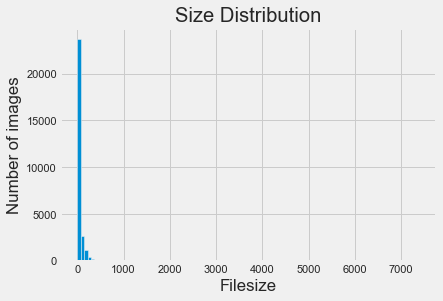

In [72]:
plt.hist(filesizes, bins=100) # `density=False` would make counts
plt.ylabel('Number of images')
plt.xlabel('Filesize');
plt.title('Size Distribution')

#### Observations:

There are apparent massive outliers which have larges file sizes when compared to the majority. Some are even 7MB in size which makes these images bigger and probably clearer. 

It may be useful to zoom in on the graph above even further to assess the distribution of the majority of the file sizes, outside of the outliers. The function below removes the outliers from the graph.

In [74]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    - points : Number of observations by numdimensions array of observations
    - threshold : The modified z-score to use as a threshold

    Returns:
    - mask : Boolean array excluding outliers

    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [78]:
filesizes = np.array(filesizes, dtype = np.float64)

Text(0.5, 1.0, 'Size Distribution (w/o Outliers)')

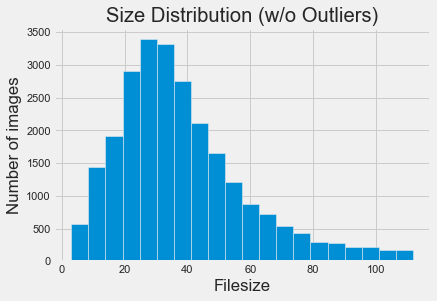

In [79]:
### Only keep non-outliers
filtered = filesizes[~is_outlier(filesizes)]

plt.hist(filtered, bins=20) # `density=False` would make counts
plt.ylabel('Number of images')
plt.xlabel('Filesize')
plt.title('Size Distribution (w/o Outliers)')

#### Observations:

Majority of the images haev around 30kb of filesizes only. It is interesting whether this may play a significant factor in predicting the breeds when most of the images sizes, effectively the quality, are smaller. Then again, I still need to maintain the file sizes small to be manageable enough when running complex algorithms because of time and performance concerns.

Based on the analysis, I believe I will need to resize all images prior to modeling.

### Image Dimensions

This looks into the photo dimensions of images. It may be noteworthy to check if image width and height do matter in making predictions.

In [86]:
### Prepare a dataframe to store file dimensions
dimension_df = pd.DataFrame(columns=['path', 
                                'width', 'height']) 

### Get file width and height
for path in tqdm(path_list):
    image = PIL.Image.open(path)
    width, height = image.size
    dimension_df = dimension_df.append({'path': path, 'width': width, 'height': height}, ignore_index = True)


### Store file sizes
dimension_df.to_csv('dimension_df.csv')

In [87]:
dimension_df.head(5)

path width height
0  images/train/m8045hqkl3wiado97pcb.jpg   500    333
1  images/train/51n7gcvmu9x2e8wfoql6.jpg   422    317
2  images/train/its279rcqnjuz6eao03w.jpg  1026   1317
3  images/train/mzhr9l61d3j4sqogbu5n.jpg   500    373
4  images/train/wurbzx6jnvgep8d4mao2.jpg   374    500

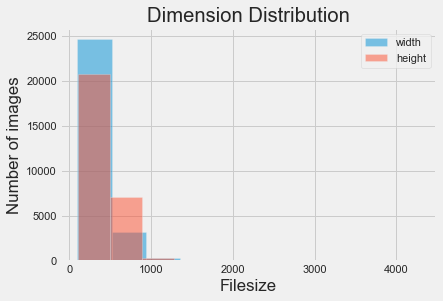

In [100]:
x = dimension_df['width']
y = dimension_df['height']

plt.hist(x, alpha=0.5, label='width')
plt.hist(y, alpha=0.5, label='height')
plt.legend(loc='upper right')
plt.title('Dimension Distribution')
plt.ylabel('Number of images')
plt.xlabel('Filesize')
plt.show()

#### Observations:

There are apparent massive outliers which have larges file dimensions when compared to the majority.

It may be useful to zoom in on the graph above even further to assess the distribution of the majority of the file dimensions, outside of the outliers. I will reuse the function above that removes outliers.

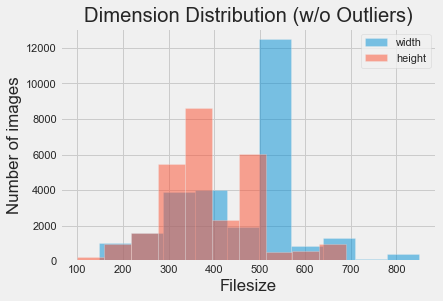

In [101]:
### Only keep non-outliers
width = dimension_df['width']
height = dimension_df['height']
width = np.array(width, dtype = np.float64)
height = np.array(height, dtype = np.float64)
width = width[~is_outlier(width)]
height = height[~is_outlier(height)]

x = width
y = height

plt.hist(x, alpha=0.5, label='width')
plt.hist(y, alpha=0.5, label='height')
plt.legend(loc='upper right')
plt.ylabel('Number of images')
plt.xlabel('Filesize')
plt.title('Dimension Distribution (w/o Outliers)')

plt.show()

#### Observations:

The height of the images looks more normally distributed versus its height. This suggests many of the photos may be taken in landscape mode. Again, it will be interesting to see if this plays a factor in predictive accuracy of our models later. But then I also believe that it might be best to resize all images prior to modeling to ensure equal weight distribution.

***

## 3: EDA - Dog Characteristics

This section includes all exploratory data analysis on the scraped dataset from dogtime. This covers different attributes of each breed.

In [7]:
### Load dog attributes dataset 
dogs_df = pd.read_csv("dogs.csv", index_col=0)

In [8]:
dogs_df.head(5)

adaptability  adapts_well_to_apartment_living  \
breed                                                                     
bulldog-english                      3                                5   
spaniel-english-springer             3                                1   
collie                               4                                3   
mastiff                              2                                2   
spaniel-english-cocker               4                                5   

                          good_for_novice_owners  sensitivity_level  \
breed                                                                 
bulldog-english                                4                  4   
spaniel-english-springer                       3                  4   
collie                                         4                  5   
mastiff                                        1                  3   
spaniel-english-cocker                         4                  5   

                          tolerates_being_alone  tolerates_cold_weather  \
breed                                                                     
bulldog-english                               3                       1   
spaniel-english-springer                      1                       3   
collie                                        2                       4   
mastiff                                       3                       4   
spaniel-english-cocker                        1                       4   

                          tolerates_hot_weather  all_around_friendliness  \
breed                                                                      
bulldog-english                               1                        4   
spaniel-english-springer                      4                        5   
collie                                        3                        5   
mastiff                                       1                        4   
spaniel-english-cocker                        3                        5   

                          affectionate_with_family  kid_friendly_dogs  ...  \
breed                                                                  ...   
bulldog-english                                  5                  4  ...   
spaniel-english-springer                         5                  5  ...   
collie                                           5                  5  ...   
mastiff                                          5                  5  ...   
spaniel-english-cocker                           5                  5  ...   

                                                                 highlights  \
breed                                                                         
bulldog-english           Bulldogs can be stubborn and lazy. Your mature...   
spaniel-english-springer  English Springer Spaniels don't like to be lef...   
collie                    The Collie is usually quiet unless she has a r...   
mastiff                   Mastiffs need daily exercise, but take into ac...   
spaniel-english-cocker    English Cocker Spaniels can be difficult to ho...   

                                                           size_description  \
breed                                                                         
bulldog-english           Mature male Bulldogs weigh about 50 pounds; ma...   
spaniel-english-springer  English Springer Spaniels weigh between 45 and...   
collie                    Males stand 24 to 26 inches tall; females are ...   
mastiff                   The minimum height for a male Mastiff is 30 in...   
spaniel-english-cocker    Male English Cocker Spaniels stand 16 to 17 in...   

                                                                personality  \
breed                                                                         
bulldog-english           Sociable and sweet, but with a reputation for ...   
spaniel-english-springer  The typical Springer is f

### Missing Values

Before anything else, I need to check if there are missing values that would require further handling such as imputation techniques. 

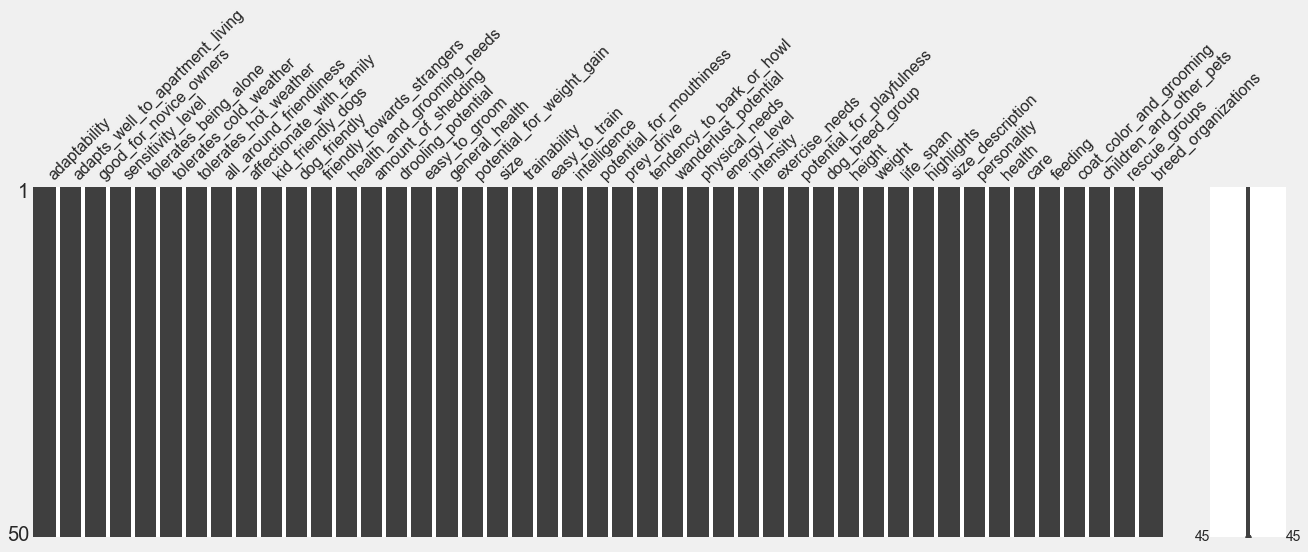

In [14]:
mno.matrix(dogs_df, figsize = (20, 6))
plt.show()

#### Observations:
Perfect! It seems we do not have any missing values from our web scraping. This means that we can proceed to further analysis without need for imputation.

### Correlation Among Attributes

Each of the numerical dog characteristic is rated from one to five stars, with five being the highest. There are five main attributes which are further broken down into sub-characteristics. Below is the breakdown.

In [10]:
main_attributes = dogs_df[['adaptability', 
                                'all_around_friendliness', 
                                'health_and_grooming_needs', 
                                'trainability', 
                                'physical_needs']]

In [11]:
specific_attributes = dogs_df[['adapts_well_to_apartment_living', 
                                'good_for_novice_owners', 
                                'sensitivity_level', 
                                'tolerates_being_alone', 
                                'tolerates_cold_weather', 
                                'tolerates_hot_weather', 
                                'affectionate_with_family', 
                                'kid_friendly_dogs', 
                                'dog_friendly', 
                                'friendly_towards_strangers', 
                                'amount_of_shedding', 
                                'drooling_potential', 
                                'easy_to_groom', 
                                'general_health', 
                                'potential_for_weight_gain', 
                                'size', 
                                'easy_to_train', 
                                'intelligence', 
                                'potential_for_mouthiness', 
                                'prey_drive', 
                                'tendency_to_bark_or_howl', 
                                'wanderlust_potential',
                                'energy_level',
                                'intensity',
                                'exercise_needs',
                                'potential_for_playfulness']]

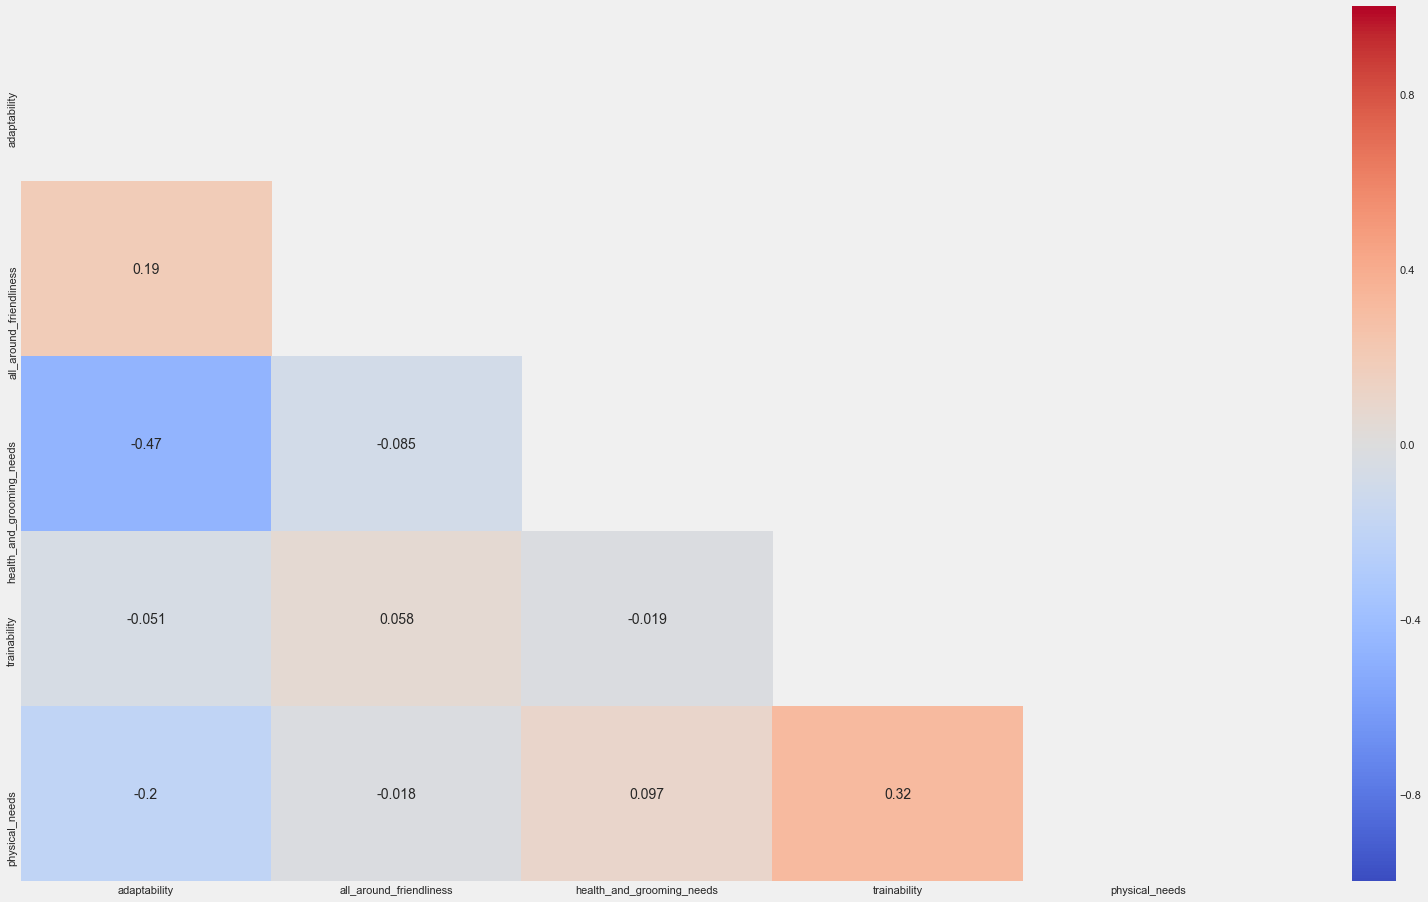

In [18]:
### Plot correlation between main attributes
f, ax = plt.subplots(figsize=(25, 15))
matrix = np.triu(main_attributes.corr())
sns.heatmap(main_attributes.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)
plt.show()

#### Observations:
It's good that the highest correlation among the main attributes has 0.32 correlation because this means that the main attributes are truly independent from each other. Each main attribute does not influence the others.

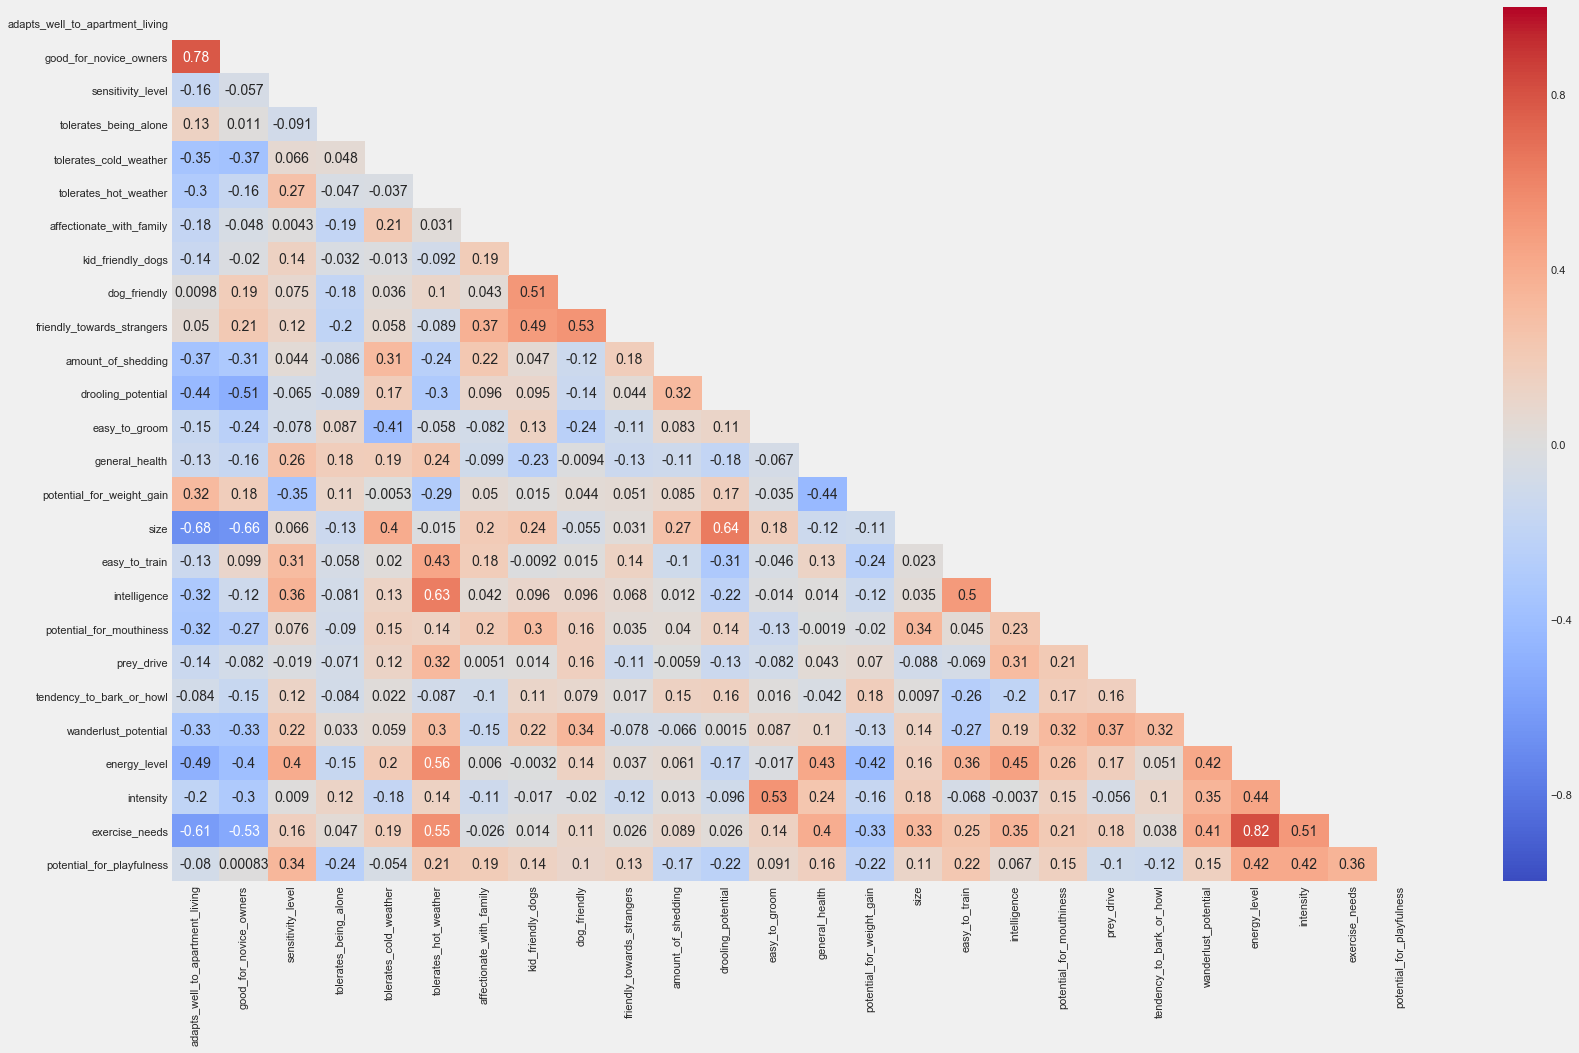

In [19]:
### Plot correlation between main attributes
f, ax = plt.subplots(figsize=(25, 15))
matrix = np.triu(specific_attributes.corr())
sns.heatmap(specific_attributes.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)
plt.show()

#### Observations

The correlation matrix above is quite reasonable as we further analyze dog breed characteristics. For example, the two most highly-correlated attributess are energy level and exercise needs. They are indeed correlated because exercise needs is dependent on the energy level available to each breed. The pair with the second highest correlation is not as straightforward as the first example. Good for novice owners has .78 correlation with adapts well to apartment living. It is interesting because being a novice owner does not automatically mean that the owner lives in the apartment. Then again, I suppose this further proves the need for this project - an owner must be prepared before committing to a pet and should know whether the breed matches his lifestyle. If he only has an apartment, then he understands that it is not best to adopt high-energy breeds. Novice owners should know better.

### Main Attributes

This section examines the main attributes of the top 50 dog breeds according to the American Kennel Club. This should help picture the factors why they are the most adopted breeds in the United States.

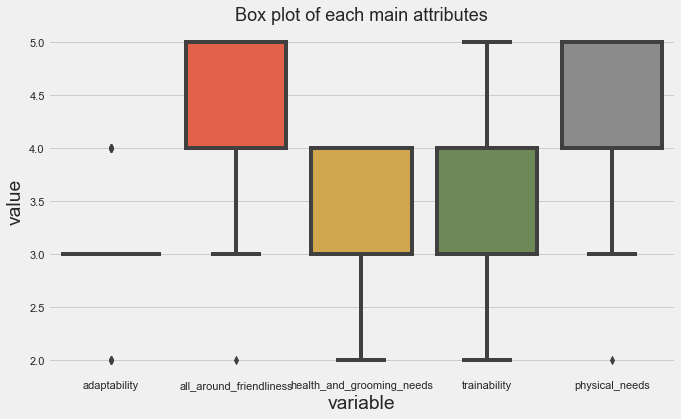

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

ax = sns.boxplot(x="variable", y="value", data=pd.melt(main_attributes))
ax.set_title('Box plot of each main attributes', fontsize= 18)
ax

#### Observations:
Adaptability does not seem to be a great factor but high all around friendliness and physical needs are significant attributes of the top breeds. It also seems that health and grooming and trainability just need to be decent, but not bad.

## Specific Attributes

This section examines the detailed attributes of the top 50 dog breeds according to the American Kennel Club. This should help picture the factors why they are the most adopted breeds in the United States.

In [36]:
dogs_df.describe().T

count  mean       std  min   25%  50%  75%  \
adaptability                      50.0  3.08  0.565685  2.0  3.00  3.0  3.0   
adapts_well_to_apartment_living   50.0  3.00  1.678191  1.0  1.00  3.0  5.0   
good_for_novice_owners            50.0  3.04  1.292995  1.0  2.00  3.0  4.0   
sensitivity_level                 50.0  4.26  0.694292  3.0  4.00  4.0  5.0   
tolerates_being_alone             50.0  1.68  0.913392  1.0  1.00  1.0  2.0   
tolerates_cold_weather            50.0  3.10  1.199490  1.0  2.00  3.0  4.0   
tolerates_hot_weather             50.0  2.86  1.069236  1.0  2.00  3.0  4.0   
all_around_friendliness           50.0  4.26  0.750782  2.0  4.00  4.0  5.0   
affectionate_with_family          50.0  4.92  0.274048  4.0  5.00  5.0  5.0   
kid_friendly_dogs                 50.0  4.16  1.017400  1.0  4.00  4.0  5.0   
dog_friendly                      50.0  3.68  1.236189  1.0  3.00  4.0  5.0   
friendly_towards_strangers        50.0  3.76  1.221575  1.0  3.00  4.0  5.0   
health_and_grooming_needs         50.0  3.18  0.747513  2.0  3.00  3.0  4.0   
amount_of_shedding                50.0  3.40  1.195229  1.0  2.25  3.0  4.0   
drooling_potential                50.0  2.28  1.641801  1.0  1.00  1.0  4.0   
easy_to_groom                     50.0  3.32  1.570649  1.0  2.00  3.0  5.0   
general_health                    50.0  2.90  1.054630  1.0  2.00  3.0  4.0   
potential_for_weight_gain         50.0  3.66  0.960655  2.0  3.00  4.0  4.0   
size                              50.0  2.86  1.261842  1.0  2.00  3.0  4.0   
trainability                      50.0  3.50  0.707107  2.0  3.00  4.0  4.0   
easy_to_train                     50.0  3.94  1.132272  1.0  3.00  4.0  5.0   
intelligence                      50.0  4.12  0.848528  2.0  4.00  4.0  5.0   
potential_for_mouthiness          50.0  3.18  1.023998  1.0  2.25  3.0  4.0   
prey_drive                        50.0  3.52  1.164790  1.0  3.00  4.0  4.0   
tendency_to_bark_or_howl          50.0  3.10  1.164965  1.0  2.00  3.0  4.0   
wanderlust_potential              50.0  3.06  1.346348  1.0  2.00  3.0  4.0   
physical_needs                    50.0  4.12  0.824126  2.0  4.00  4.0  5.0   
energy_level                      50.0  4.02  0.999796  2.0  3.00  4.0  5.0   
intensity                         50.0  3.36  1.045105  1.0  3.00  3.0  4.0   
exercise_needs                    50.0  3.90  1.147313  1.0  3.00  4.0  5.0   
potential_for_playfulness         50.0  4.48  0.762381  2.0  4.00  5.0  5.0   

                                 max  
adaptability                     4.0  
adapts_well_to_apartment_living  5.0  
good_for_novice_owners           5.0  
sensitivity_level                5.0  
tolerates_being_alone            5.0  
tolerates_cold_weather           5.0  
tolerates_hot_weather            4.0  
all_around_friendliness          5.0  
affectionate_with_family         5.0  
kid_friendly_dogs                5.0  
dog_friendly                     5.0  
friendly_towards_strangers       5.0  
health_and_grooming_needs        4.0  
amount_of_shedding               5.0  
drooling_potential               5.0  
easy_to_groom                    5.0  
general_health                   5.0  
potential_for_weight_gain        5.0  
size                             5.0  
trainability                     5.0  
easy_to_train                    5.0  
intelligence                     5.0  
potential_for_mouthiness         5.0  
prey_drive                       5.0  
tendency_to_bark_or_howl         5.0  
wanderlust_potential             5.0  
physical_needs                   5.0  
energy_level                     5.0  
intensity                        5.0  
exercise_needs                   5.0  
potential_for_playfulness        5.0

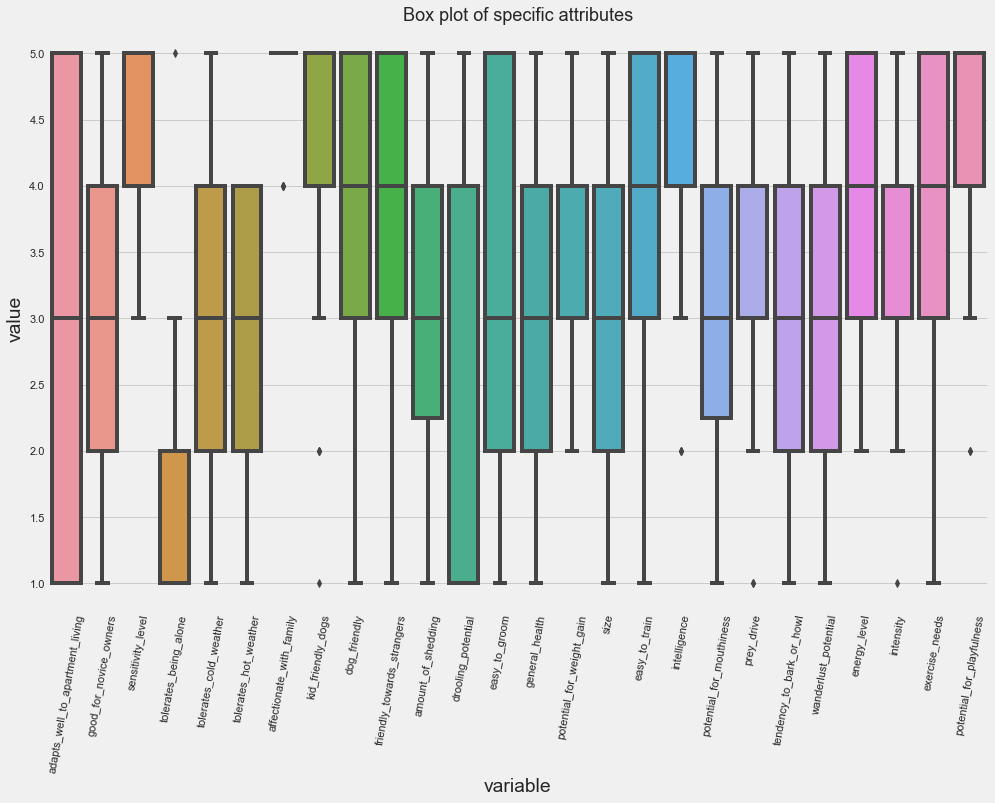

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({'font.size': 16})

ax = sns.boxplot(x="variable", y="value", data=pd.melt(specific_attributes))
ax.set_title('Box plot of specific attributes', fontsize= 18)
plt.setp(ax.get_xticklabels(), rotation=80)
ax

#### Observations:
Based on the box plot above, US dog owners tend to favor breeds that have high sensitivity levels, kid friendly, intelligent and playful. Makes sense because I suppose the major reason people get dogs is for companionship. Other factors would matter for much more specific purposes of owning a dog such as security, bomb detection, etc.

***

## 4: EDA - Dogs for Adoption

This is where we deep-dive into the details of the dogs for adoption. Will there be definite reasons why they are adopted?

In [46]:
adoption_df = pd.read_csv('adoption_dogs.csv', index_col = 0)

In [47]:
adoption_df.head(5)

link  \
0  https://www.petfinder.com/dog/cary-in-ny-so-ge...   
1  https://www.petfinder.com/dog/darlin-33661138/...   
2  https://www.petfinder.com/dog/thea-queen-47256...   
3  https://www.petfinder.com/dog/chloe-47211945/n...   
4  https://www.petfinder.com/dog/sheba-47211940/n...   

                              name     sex     age                 breed  
0  Cary in NY - So Gentle & Sweet!  Female   Young        Great Pyrenees  
1                           Darlin  Female   Young      Pit Bull Terrier  
2                       Thea Queen  Female   Adult  Pit Bull Terrier Mix  
3                            Chloe  Female  Senior  Pit Bull Terrier Mix  
4                            Sheba  Female   Adult  Pit Bull Terrier Mix

### Gender

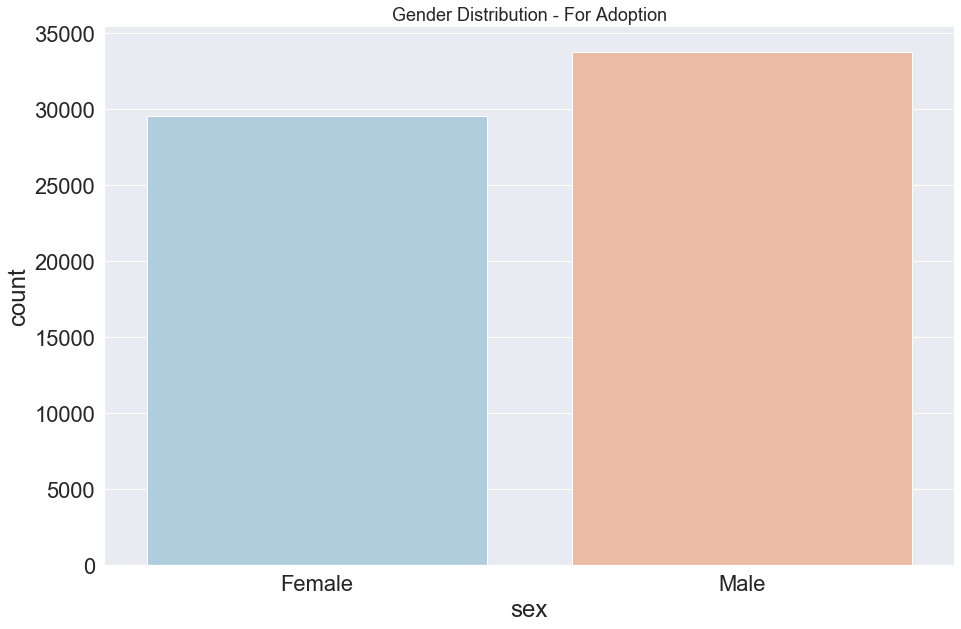

In [54]:
ax = sns.catplot(x="sex", kind="count", palette="RdBu_r", data=adoption_df, height=9, aspect=15/10)
sns.set(font_scale=2)

plt.title('Gender Distribution - For Adoption', {'fontsize': 18})
plt.show()

#### Observations:

There are more male dogs for adoption than female but there is not a huge discrepancy. Gender plays only a small factor in abandoning dogs and choosing them for adoption.

### Age Group

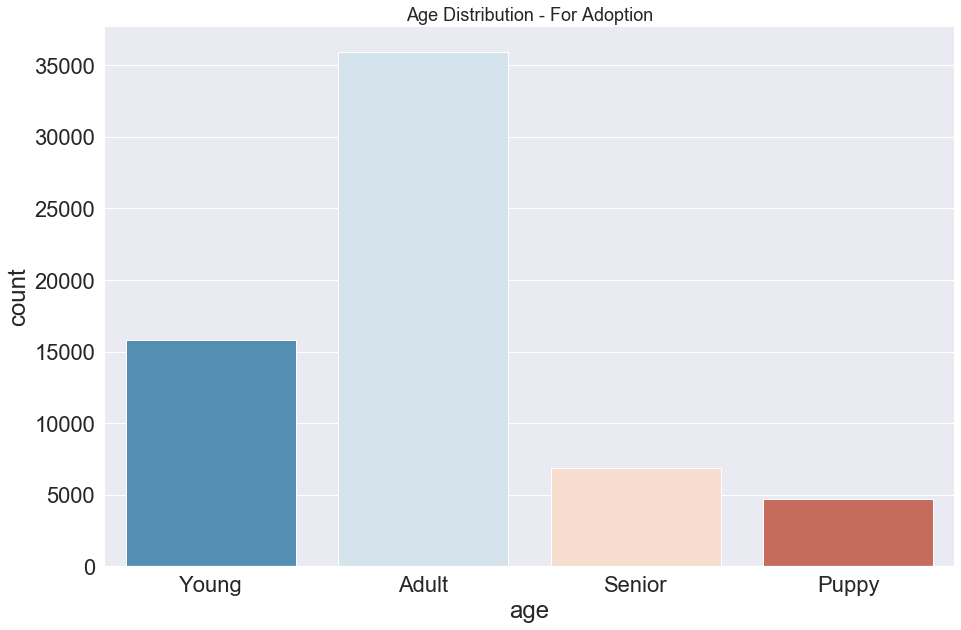

In [56]:
ax = sns.catplot(x="age", kind="count", palette="RdBu_r", data=adoption_df, height=9, aspect=15/10)
sns.set(font_scale=2)

plt.title('Age Distribution - For Adoption', {'fontsize': 18})
plt.show()

#### Observations:

There are very few puppies that are up for adoption when compared to the other age groups. This probably means that there is a faster adoption turnaround rate for puppies, which makes sense because puppies are cuter and are still more trainable. You will also have the puppies for longer. 

The second fewest age bracket is the Senior dogs, which is probably because there are not many of them. They are also more likely to be euthanized, especially if they are already showing ailments due to age. Nevertheless, this is very depressing. These senior dogs deserve to have a second change at a happy home. 

Around half of all dogs for adoption are in the adult age group. This bracket also covers the widest range of age in years.

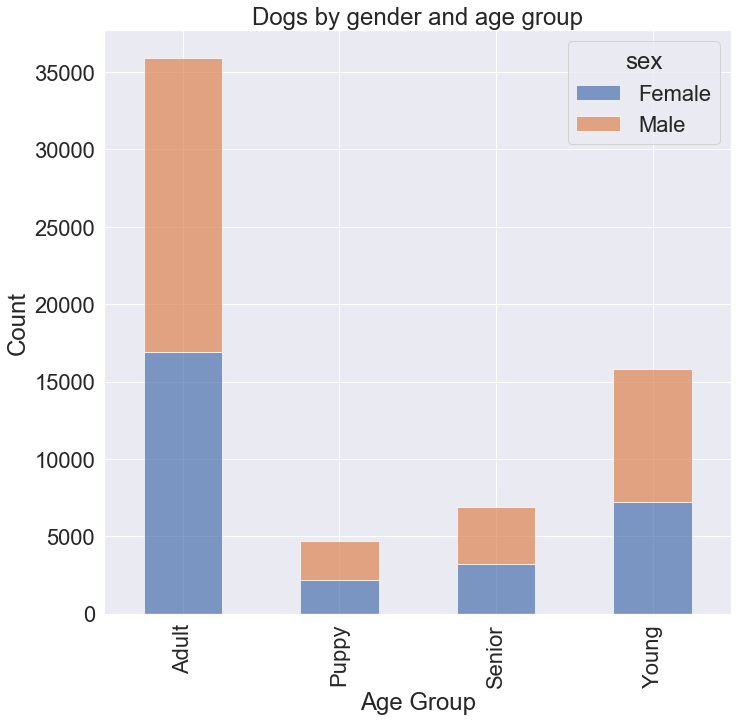

In [59]:
age = adoption_df.groupby(['age','sex']).age.count().unstack()
p1 = age.plot(kind = 'bar', stacked = True, 
                   title = 'Dogs by gender and age group', 
                   alpha = .70, figsize=(10,10))
p1.set_xlabel('Age Group')
p1.set_ylabel('Count')
plt.show()

#### Observations:

All age groups are pretty much equally divided by gender. There is no uncommon trend to note here.

### Breeds

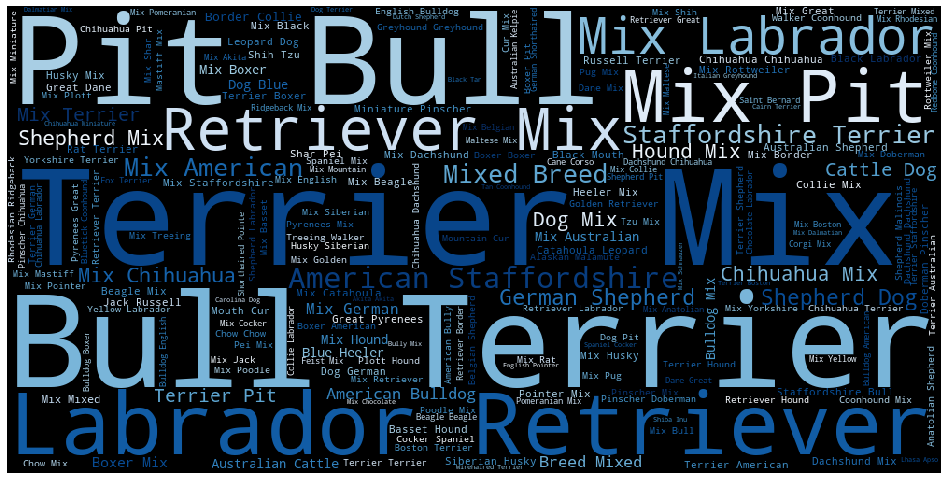

In [64]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word = " ".join(breed for breed in adoption_df['breed'])

### Convert list to string and generate graph ###
unique_string=(" ").join(word)
wordcloud = WordCloud(width = 1000, height = 500, colormap="Blues").generate(word)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

plt.show()
plt.close()

#### Observations:

Pit Bulls and similar breeds like the Bull Terrier are mostly the ones for adoption. It is also apparent that many of the dogs are of mixed breeds, which means they do not have registration papers.